In [73]:
import cv2 as cv
import numpy as np
import pandas as pd
from datetime import datetime
import imutils
from matplotlib import pyplot as plt 

%matplotlib inline

In [83]:
TITLE_FONT_SIZE=20
FIG_SIZE=(12,12)
BLUR_KERNEL=(3,3)

def describe_data(numpy_array):
    df=pd.DataFrame({"a": numpy_array.flatten()})
    print(df.describe())

def plot_my_image(img,
                  plot_gray=False,
                  is_gray=False,
                 title=''):
    if is_gray==True:
        pass
    elif is_gray==False:
        img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    fig = plt.figure(figsize = FIG_SIZE) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    
    today=datetime.now()
    today.isoformat()
    ax.set_title(title+' '+today.isoformat(),fontsize = TITLE_FONT_SIZE)
    if plot_gray==True: 
        ax.imshow(img, interpolation='none',cmap='gray')
    elif plot_gray==False:
        ax.imshow(img, interpolation='none')
    plt.show()
    
def crop_background_with_mask(img,
                              mask):
    # load background (could be an image too)
    bk = np.full(img.shape, 255, dtype=np.uint8)  # white bk, same size and type of image
    #bk = cv.rectangle(bk, (0, 0), (int(img.shape[1] / 2), int(img.shape[0] / 2)), 0, -1)  # rectangles
    #bk = cv.rectangle(bk, (int(img.shape[1] / 2), int(img.shape[0] / 2)), (img.shape[1], img.shape[0]), 0, -1)

    # get masked foreground
    fg_masked = cv.bitwise_and(img,
                               img,
                               mask=mask)
    # get masked background, mask must be inverted 
    mask = cv.bitwise_not(mask)
    bk_masked = cv.bitwise_and(bk, 
                               bk,
                               mask=mask)
    # combine masked foreground and masked background 
    final = cv.bitwise_or(fg_masked, 
                          bk_masked)
    mask = cv.bitwise_not(mask)  # revert mask to original    
    return final

def rotate_image(img,angle):
    
    rotated = imutils.rotate(img,
                             angle)
    return rotated

def rotate_image_2(image,
                   angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    scale=1.0
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv.getRotationMatrix2D((cX, cY), -angle, scale)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv.warpAffine(image, M, (nW, nH))

def remove_background(img_original,
                      plot_images=True,
                      mythreshold=220,
                      myminLineLength=500,
                      mymaxLineGap=100,
                      mythickness=300,
                      is_gray=True,
                      blurthat=True,
                      blur_kernel=BLUR_KERNEL,
                      area_min=200,
                     ):
    if is_gray==True:
        red_channel=img_original
    elif is_gray==False:
        red_channel = img_original[:,:,2]
        gray = cv.cvtColor(img_original, cv.COLOR_BGR2GRAY)
        
    if blurthat==True:
        blurred =cv.blur(red_channel,ksize=blur_kernel)
    elif blurthat==False:
        blurred=red_channel
        
    if plot_images==True: 
        plot_my_image(blurred,False,False,title='blurred')
        
    (mu, sigma) = cv.meanStdDev(red_channel)
    edges = cv.Canny(image=blurred, 
                     threshold1=int(mu - sigma),
                     threshold2=int(mu + sigma))
    
    if plot_images==True: 
        plot_my_image(edges,False,title='edges')
        
    edges_without_dots=remove_white_small_dots(edges,area_min=area_min)    
    
    if plot_images==True: 
        plot_my_image(edges_without_dots,False,title='edges 2')
    
    lines = cv.HoughLinesP(edges_without_dots,
                            rho=1, 
                            theta=np.pi / 180,
                            threshold=mythreshold,#220
                            minLineLength=myminLineLength,#500
                            maxLineGap=mymaxLineGap #100
                            )
    
    print(f'Total lines: {len(lines)}')
    baseline=np.zeros(red_channel.shape)
    temp_img=img_original
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv.line(baseline, 
                (x1, y1), 
                (x2, y2), 
                color=255, 
                thickness=mythickness)

    baseline=np.uint8(baseline)
    
    if plot_images==True: 
        plot_my_image(baseline,False,title='baseline')
    
    return blurred,edges,edges_without_dots,baseline

def normalize_image(img):
    
    red_channel = img_original[:,:,2]
    normalized=cv.equalizeHist(red_channel)
    return normalized


def remove_white_small_dots(img,area_min=100):
    # Taken from https://stackoverflow.com/a/57285053/10491422
    # convert to binary by thresholding
    ret, binary_map = cv.threshold(img,127,255,0)

    # do connected components processing
    nlabels, labels, stats, centroids = cv.connectedComponentsWithStats(binary_map,
                                        None, 
                                        None, 
                                        None, 
                                        8, 
                                        cv.CV_32S)

    #get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv.CC_STAT_AREA]

    result = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if areas[i] >= area_min:   #keep
            result[labels == i + 1] = 255
            
    return result

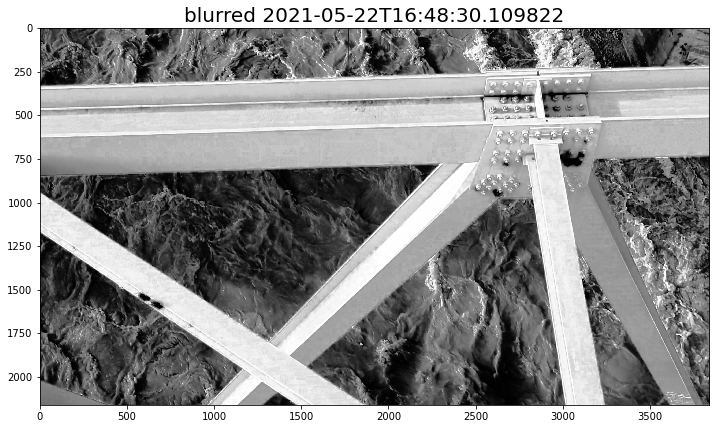

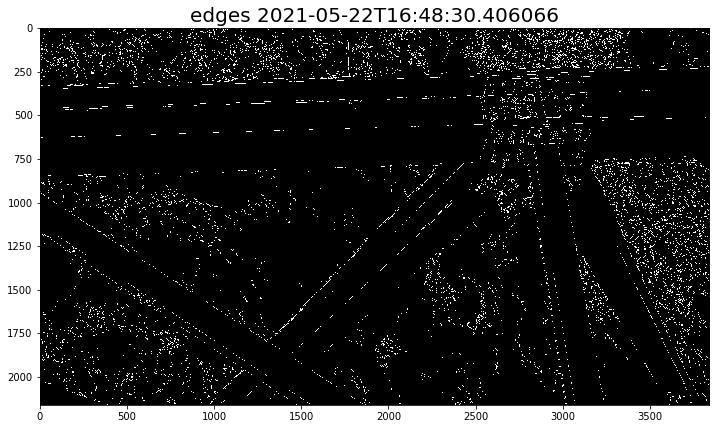

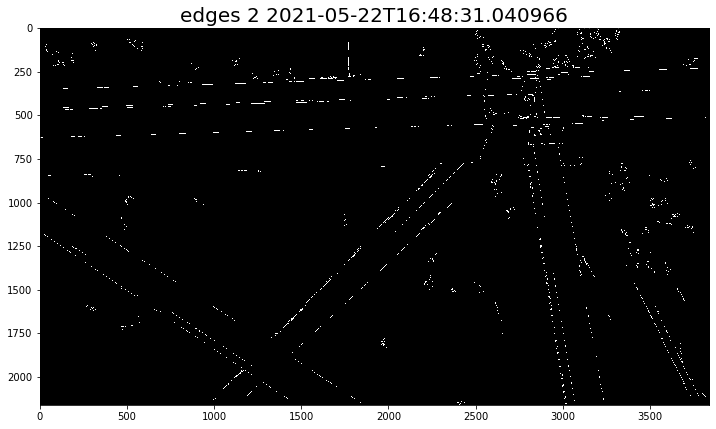

Total lines: 46


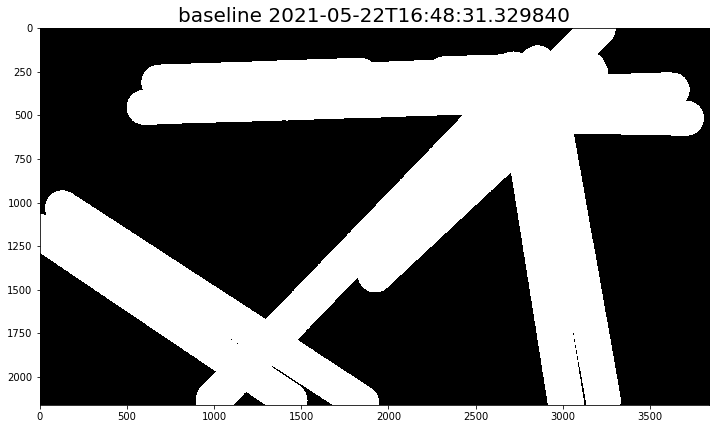

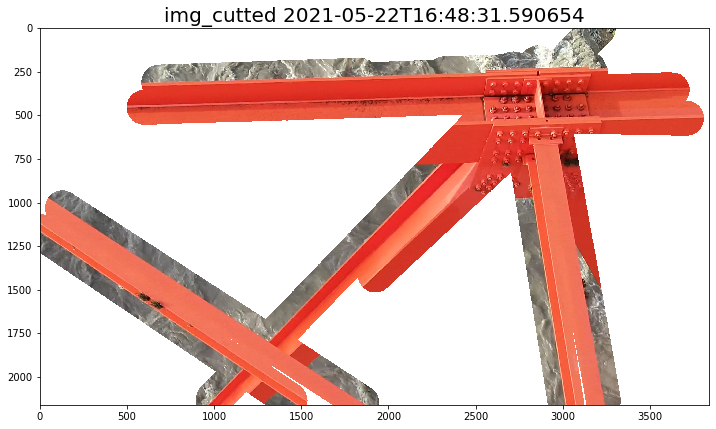

In [89]:
img_original = cv.imread("image.jpg", cv.IMREAD_UNCHANGED)

normalized=normalize_image(img_original)

blurred,edges,edges_without_dots,baseline_1=remove_background(normalized,
                            plot_images=True,
                            mythreshold=150,
                            myminLineLength=800,
                            mymaxLineGap=500,
                            mythickness=200,
                            blur_kernel=(3,3),
                            area_min=200,
                            )

#plot_my_image(baseline_1,False)
#img_original_rotated=rotate_image_2(img_original,90)
#baseline_2=remove_background(img_original_rotated,False,my_thickness=thick)
#baseline_2=rotate_image_2(baseline_2,-90)
#plot_my_image(baseline_2,False)
#baseline_final=cv.add(baseline_1,baseline_2)
#plot_my_image(baseline_final,False)

img_cutted=crop_background_with_mask(img_original,baseline_1)
plot_my_image(img_cutted,False,title='img_cutted')

In [90]:
cv.imwrite('cutted.png',img_cutted)

True

In [ ]:
img_original = cv.imread("image2.jpg", cv.IMREAD_UNCHANGED)
normalized=normalize_image(img_original)
plot_my_image(img_original,False)
describe_data(img_original)
print(img_original[0][150])
plot_my_image(normalized,False)
describe_data(normalized)
print(normalized[0][150])

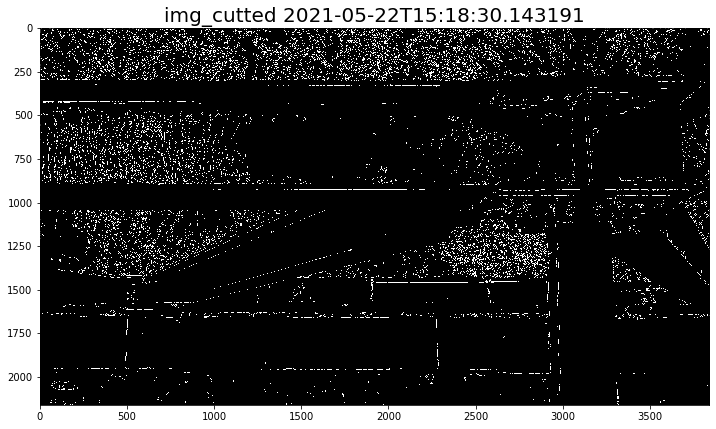

In [42]:
plot_my_image(edges,False,title='img_cutted')

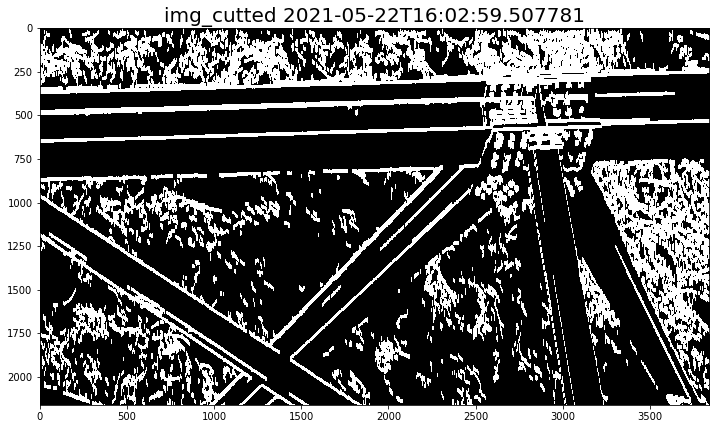

In [72]:
temp_img=edges
temp_img=cv.dilate(temp_img, kernel=(3,3), iterations=15)
temp_img=cv.erode(temp_img, kernel=(3,3), iterations=10)
temp_img=cv.dilate(temp_img, kernel=(3,3), iterations=15)
temp_img=np.uint8(temp_img)
plot_my_image(temp_img,False,title='img_cutted')

In [58]:
print(describe_data(temp_edges))
print(temp_edges.dtype)

                  a
count  8.294400e+06
mean   1.967593e-03
std    1.140396e+02
min   -1.020000e+03
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    1.020000e+03
None
float64


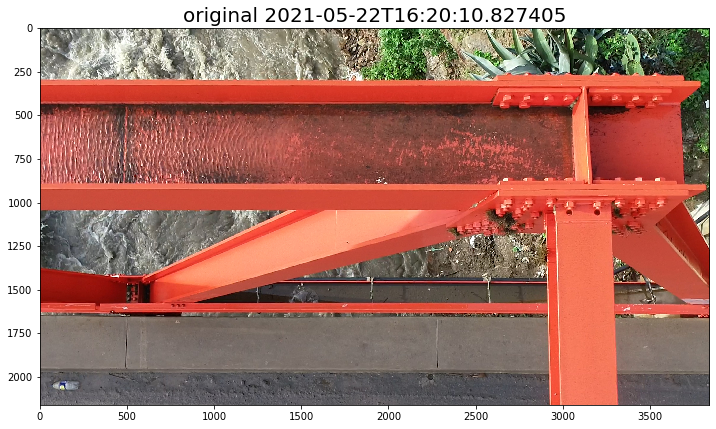

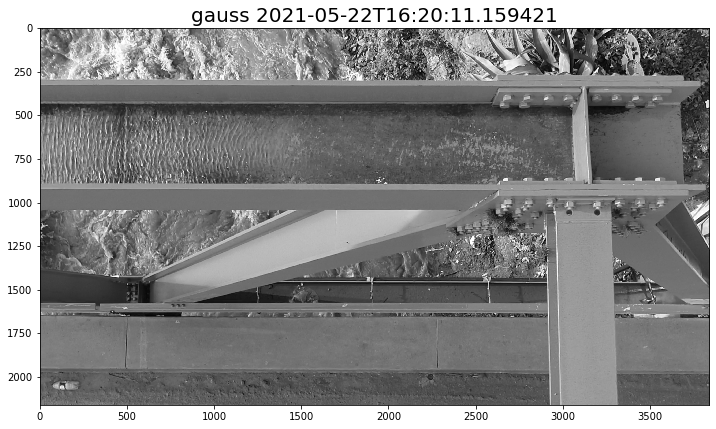

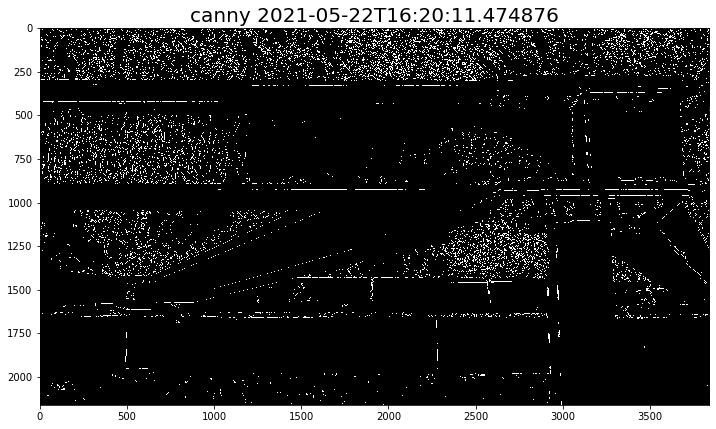

He encontrado 7175 objetos


TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [79]:
# Cargamos la imagen
original = cv.imread("image2.jpg")
plot_my_image(original,False,title='original')
# Convertimos a escala de grises
gris = cv.cvtColor(original, cv.COLOR_BGR2GRAY)
 
# Aplicar suavizado Gaussiano
gauss = cv.GaussianBlur(gris, (5,5), 0)

plot_my_image(gauss,False,title='gauss')
 
# Detectamos los bordes con Canny
canny = cv.Canny(gauss, 50, 150)
 
plot_my_image(canny,False,title='canny')
 
# Buscamos los contornos
(contornos,_) = cv.findContours(canny.copy(), 
                                cv.RETR_EXTERNAL, 
                                cv.CHAIN_APPROX_SIMPLE)
 
# Mostramos el número de monedas por consola
print("He encontrado {} objetos".format(len(contornos)))

plot_my_image(contornos,False,title='canny')
